## Resumo descritivo

Este script realiza a simulação de pontos de descartes irregulares em ruas dos bairros de Belém, a partir dos dados estimados de ocorrências por bairro.

**1. Download da malha viária**

Utilizando OSMnx, o código baixa a rede viária de Belém (tipo drive), convertendo o grafo para GeoDataFrame contendo apenas as arestas (ruas)

**2. Função para gerar pontos aleatórios**
* Recebe uma geometria de linha (rua)
* Gera uma distância aleatória ao longo da rua
* Retorna um ponto interpolado nesta posição
geom.interpolate(distancia_random)

**3. Carregamento e reprojeção dos bairros**
* Lê o arquivo shape_bairros.gpkg
* Renomeia coluna para "Bairro"
* Reprojeta para EPSG:4674 (coordenadas geográficas)
* Reprojeta também as ruas para o mesmo CRS.

**4. Carregamento da tabela de descartes**
* Lê Descartes_RF.csv
* Seleciona apenas: Bairro e N_descartes
* Cria lista dos bairros presentes no dataset.

**5. Geração de pontos aleatórios por bairro**
* Para cada bairro:
* Recupera o número estimado de descartes
* Seleciona o polígono correspondente
* Calcula a interseção entre ruas e o bairro
  * Se houver ruas:
    * Gera N pontos aleatórios usando a função definida
    * Armazena o ponto e o respectivo bairro

**6. Criação do GeoDataFrame os pontos aleatório**
*  Define CRS como EPSG:4326
* Extrai latitude e longitude das geometrias

**7. Classificação dos pontos por categoria**

Define uma lista de bairros "prioritários" (ex.: bairros com dados observados).
Classifica cada ponto como:Dados (cor azul) Estimados (cor vermelha)

**8. Salvar arquivo**
Armazena as coordenadas dos pontos para cada bairro em um dataframe geopandas.

**9. Exemplo do mapa interativo (Plotly)**

   Exibe o mapa interativo com os marcadores de descartes irregulares



In [1]:
import os
import random
import osmnx as ox
import geopandas as gpd
import pandas as pd
import plotly.express as px
# criar coluna de categoria de cor
import warnings
# warnings.filterwarnings(
#     "ignore",
#     message=".*scatter_mapbox.*deprecated.*")

random.seed(42)

# ============================================================
# 1. BAIXAR MALHA VIÁRIA DE BELÉM
# ============================================================
print("Baixando ruas de Belém...")
G = ox.graph_from_place("Belém, Pará, Brazil", network_type="drive")
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

Baixando ruas de Belém...


In [2]:
# ============================================================
# 2. FUNÇÃO: GERAR PONTO ALEATÓRIO EM UMA RUA
# ============================================================
def gerar_ponto_aleatorio_em_rua(geom):
    distancia_random = random.uniform(0, geom.length)
    return geom.interpolate(distancia_random)

# ============================================================
# 3. CARREGAR SHAPE DOS BAIRROS
# ============================================================
path = "/home/akel/PycharmProjects/Data_ambiental/data/process/"
arquivo = os.path.join(path, "shape_bairros.gpkg")

gdf_bairros = gpd.read_file(arquivo).rename(columns={'NM_BAIRRO': 'Bairro'})
bairros4674 = gdf_bairros.to_crs("EPSG:4674")
edges = edges.to_crs("EPSG:4674")

# ============================================================
# 4. CARREGAR TABELA DE DESCARTES IRREGULARES ML
# ============================================================
df_temp = pd.read_csv(os.path.join(path, "Descartes_RF.csv"))
df_descartes = (
    df_temp[['Bairro', 'Depósitos Irregulares est.']]
    .rename(columns={'Depósitos Irregulares est.': 'N_descartes'})
)

lista_bairros = df_descartes['Bairro'].tolist()

# Reset de índices para evitar problemas no overlay
# edges = edges.reset_index(drop=True)
# bairros4674 = bairros4674.reset_index(drop=True)
edges.reset_index(drop=True, inplace=True)
bairros4674.reset_index(drop=True, inplace=True)

# ============================================================
# 5. GERAR PONTOS ALEATÓRIOS POR BAIRRO
# ============================================================
pontos = []
ponto_bairro = []   # <- necessário para colorir depois

for bairro in lista_bairros:
    # Número de descartes no bairro
    N = int(df_descartes.loc[df_descartes["Bairro"] == bairro, "N_descartes"].iloc[0])

    # Seleciona o polígono do bairro
    bairro_geom = bairros4674[bairros4674["Bairro"] == bairro]

    # Interseção com ruas
    ruas_no_bairro = gpd.overlay(edges, bairro_geom, how="intersection")

    if ruas_no_bairro.empty:
        #print(f"⚠️ Sem ruas no bairro: {bairro}")
        continue

    # Gera N pontos aleatórios
    for _ in range(N):
        rua_escolhida = ruas_no_bairro.sample(1).iloc[0]
        ponto = gerar_ponto_aleatorio_em_rua(rua_escolhida.geometry)
        pontos.append(ponto)
        ponto_bairro.append(bairro)   # ← registrando o bairro do ponto

# ============================================================
# 6. CRIAR GEODataFrame DOS PONTOS
# ============================================================
gdf_pontos = gpd.GeoDataFrame(
    {"Bairro": ponto_bairro},
    geometry=pontos,
    crs="EPSG:4326"
)

gdf_pontos["lat"] = gdf_pontos.geometry.y
gdf_pontos["lon"] = gdf_pontos.geometry.x

# ============================================================
# 7. LISTA DE BAIRROS QUE FICARÃO EM AZUL
# ============================================================
bairros_azuis = [
    "Campina", "Cidade Velha", "Marco", "São Brás", "Umarizal", "Bengui",
    "Coqueiro", "São Clemente", "Tapanã", "Castanheira", "Marambaia",
    "Souza", "Val-de-Cães", "Guamá", "Jurunas", "Paracuri", "Ponta Grossa",
    "Miramar", "Pedreira", "Sacramenta", "Telégrafo"
]

gdf_pontos["Cor"] = gdf_pontos["Bairro"].apply(
    lambda b: "Dados" if b in bairros_azuis else "Estimados")

In [3]:
# -----------------------------------------------------
# *)SALVAR O ARQUIVO
# -----------------------------------------------------
filename="Pontos_descartes_ML.gpkg"
path='/home/akel/PycharmProjects/Data_ambiental/data/process/'
arquivo = os.path.join(path, filename)

if os.path.exists(arquivo):
    print("GPKG já existe. Não sobrescrever.")
else:
    gdf_pontos.to_file(arquivo, driver="GPKG")
    print("Arquivo GPKG salvo!")

GPKG já existe. Não sobrescrever.


---

/tmp/ipykernel_92192/1392967335.py:13: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


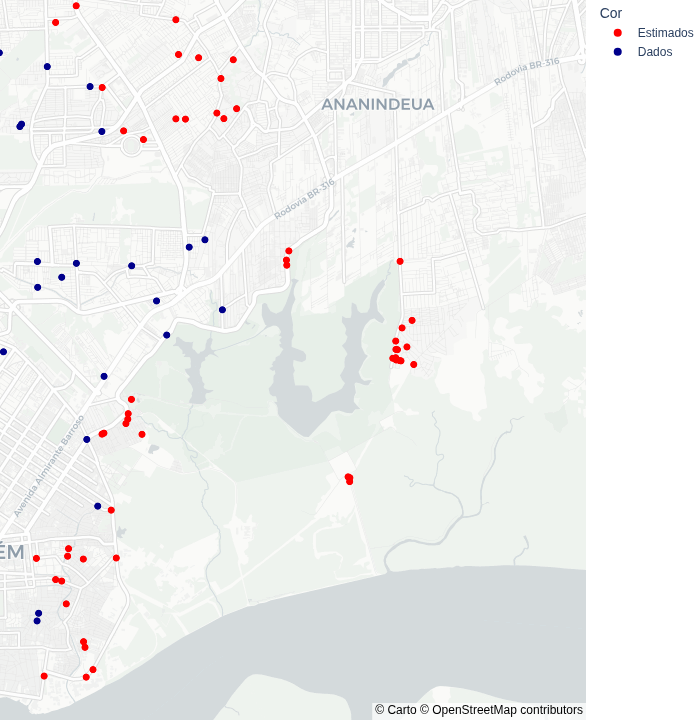

In [6]:
# ============================================================
# MAPA INTERATIVO EM PLOTLY
# ============================================================
#centro_lat = gdf_pontos["lat"].median()
#centro_lon = gdf_pontos["lon"].median()
filename2="Pontos_descartes_ML.gpkg"
path='/home/akel/PycharmProjects/Data_ambiental/data/process/'
arquivo2 = os.path.join(path, filename2)
gpd_p = gpd.read_file(arquivo2)

centro_lat,centro_lon =-1.417897, -48.4162631

fig = px.scatter_mapbox(
    gpd_p,
    lat="lat",
    lon="lon",
    color="Cor",
    hover_name="Bairro",
    color_discrete_map={"Dados": "darkblue", "Estimados": "red"},
    zoom=12,
    height=720
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": centro_lat, "lon": centro_lon}, 
    margin={"r":0, "t":0, "l":0, "b":0}
)

fig.update_traces(marker=dict(size=8))

#fig.show(config={"scrollZoom": True})
fig.show('png')

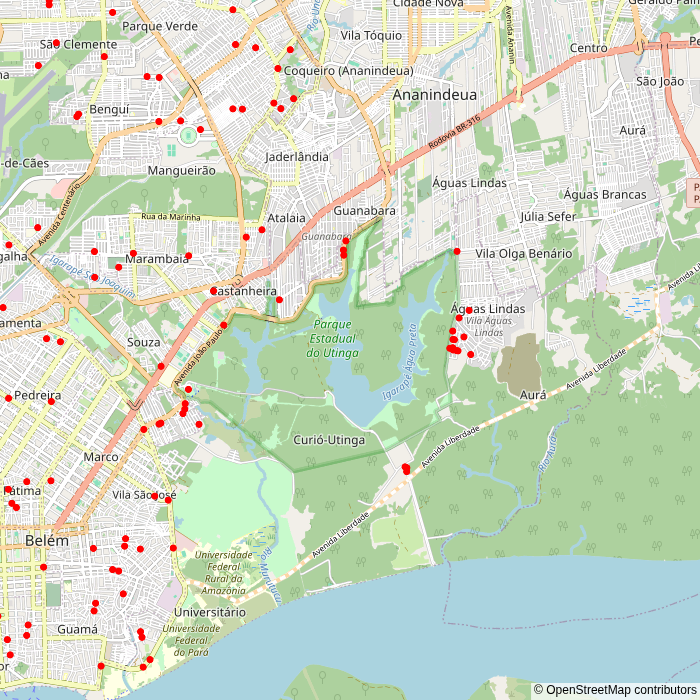

In [7]:
# ============================================================
#  MAPA INTERATIVO COM PLOTLY(extra)
# ============================================================
#centro_lat = gdf_pontos["lat"].median()
#centro_lon = gdf_pontos["lon"].median()



centro_lat,centro_lon =-1.417897, -48.4162631

fig = px.scatter_map(
    gdp_p ,
    lat="lat",
    lon="lon",
    zoom=12,
    height=700,
)

fig.update_layout(
    map_style="open-street-map",
    map_center={"lat": centro_lat, "lon": centro_lon},
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.update_traces(marker=dict(size=8, color="red"))

#fig.show(config={"scrollZoom": True})
fig.show('png')

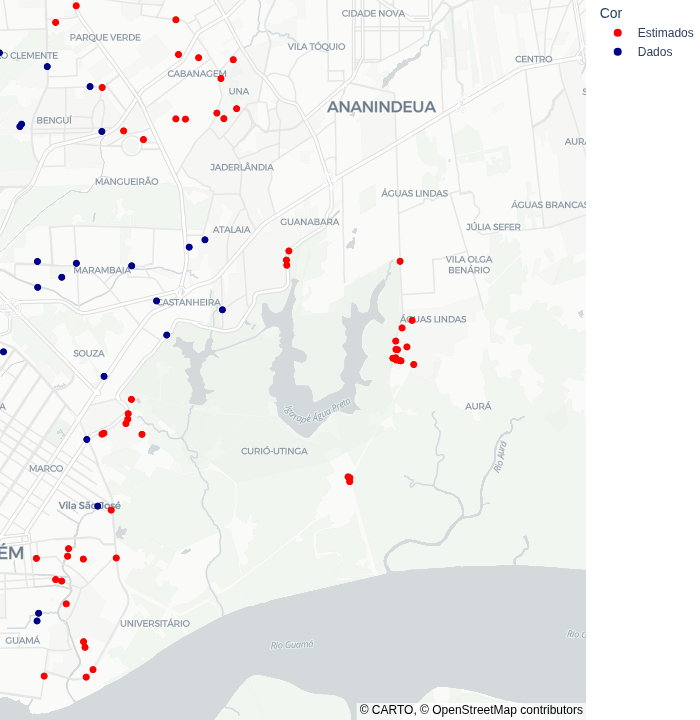

In [11]:
# ============================================================
# 8. MAPA INTERATIVO EM PLOTLY
# ============================================================
centro_lat, centro_lon = -1.417897, -48.4162631

fig = px.scatter_map(
    gdp_p,
    lat="lat",
    lon="lon",
    color="Cor",
    hover_name="Bairro",
    color_discrete_map={"Dados": "darkblue", "Estimados": "red"},
    zoom=12,
    height=720
)

fig.update_layout(
    map_style="carto-positron",
    map_center={"lat": centro_lat, "lon": centro_lon}, 
    margin={"r":0, "t":0, "l":0, "b":0}
)

fig.update_traces(marker=dict(size=8))

#fig.show(config={"scrollZoom": True})
fig.show('png')